# Spatial Modelling

This notebook will present some methods for spatial modelling, using the [AirBnB properties in San Diego, CA](https://geographicdata.science/book/data/airbnb/regression_cleaning.html) dataset and the Georgia Housing dataset

<img src="images/spatial-models.png" alt="Drawing" width="1100" height="600"/>

In [1]:
from libpysal import weights
from pysal.explore import esda
import numpy as np
import geopandas
import matplotlib.pyplot as plt

from pysal.model import spreg
from spreg import OLS
from spreg import GM_Lag
from spreg import GM_Error_Het

In [2]:
db = geopandas.read_file("data/regression_db.geojson")
variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

In [3]:
knn = weights.KNN.from_dataframe(db, k=4)

# Row standardise weights
knn.transform = "R"

# Create spatial lags
spatial_lag = weights.lag_spatial(knn, db[variable_names].values)
spatial_lag_names = variable_names + [x + "_lag" for x in variable_names]

/Users/nicole_kan/opt/anaconda3/envs/gdai-env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 19 disconnected components.
  warnings.warn(message)


# Spatial Lag Model

## Exogenous Regressors

$P_i = \alpha + \beta X_i + \delta \sum_j w_{ij} X'_i + \epsilon_i$, where

- $X_i'$ is a subset of $X$ (or could be all of $X$) that we want to include spatial lags for,

- If $W$ is row-standardised (usually should) ⇒ then $\sum_j w_{ij} X'_i$ captures the average value of that feature $X$ in the surrounding locations around $i$ ⇒ this is called the spatial lag of $X_i$

In [4]:
m1 = OLS(db[['log_price']].values, np.append(db[variable_names].values, spatial_lag, axis=1), 
         w=knn, spat_diag=True, name_x=spatial_lag_names, name_y='log_price')

print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          21
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6089
R-squared           :      0.6864
Adjusted R-squared  :      0.6854
Sum squared residual:    1248.247                F-statistic           :    666.3971
Sigma-square        :       0.205                Prob(F-statistic)     :           0
S.E. of regression  :       0.453                Log likelihood        :   -3817.804
Sigma-square ML     :       0.204                Akaike info criterion :    7677.608
S.E of regression ML:      0.4520                Schwarz criterion     :    7818.679

-----------------------------------------------------------------------------

## Endogenous Regressors

This model violates some of the assumptions on which OLS relies ⇒ itincludes an endogenous variable $P_i$ on the right-hand side ⇒ we will need a new estimation method to obtain reliable coefficients (not OLS)

$P_i = \alpha + \lambda \sum_j w_{ij} P_i + \beta X_i + \epsilon_i$, where

Conceptually ⇒ it’s NOT “the effect of the price in neighbouring locations j on that of location i” It is assumed to be a “joint decision”: rather than some houses setting their price first and that having a subsequent effect on others, what the equation models is an “interdependent process by which each owner sets her own price *taking into account* the price that will be set in neighboring

In [5]:
m2 = GM_Lag(db[['log_price']].values, db[variable_names].values,
                  w=knn, spat_diag=True, w_lags=1,
                  name_x=variable_names, name_y='log_price')
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          12
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6098
Pseudo R-squared    :      0.6965
Spatial Pseudo R-squared:  0.6812

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       3.3791238       0.0631524      53.5074755       0.0000000
        accommodates       0.0730300       0.0048944      14.9212674       0.0000000
           bathrooms       0.1729241       0.0105475      1

The AKJ test tests if there is any spatial autocorrelation in the residuals. If the p-value is lower than the significance level, then there is still spatial autocorrelation present --> need to use the Spatial Error model.

# Spatial Error Model

This model also violates the assumptions about the error term in a classical OLS model

$P_i = \alpha + \sum_k \beta_k X_{ki} + u_i$

$u_i = \lambda u_{lag-i} + \epsilon_i$

$u_{lag-i} = \sum_j w_{ij}u_j$

This model emerges from the presence of spatial dependence in the error term of a spatial unit and the corresponding neighboring units

In [6]:
m3 = GM_Error_Het(db[['log_price']].values, db[variable_names].values, w=knn, 
                                 name_y="log_price", name_x=variable_names)
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
Pseudo R-squared    :      0.6676
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       4.4125766       0.0185015     238.4976766       0.0000000
        accommodates       0.0749992       0.0063639      11.7850952       0.00

# Geographically Weighted Regression

Key strength of GWR: identify patterns of spatial variation in associations between pairs of variables --> can have different coefficients varying across all regions

* Because relationships between variables measured at different locations might not be constant over space --> overcomes limitation of OLS regression of generating global set of estimates
* Explores spatial non-stationarity in estimated marginal effects --> produces a local summary of model --> allowing detection of local variations in spatial behaviour --> regression coefficients are produced for every spatial zone

## Bandwidth Selection

The spatial weighting at given location is done by using a spatial weighting function, considering the distance between locations and the bandwidth (defined by the user, or searched automatically based on error minimization):

When the bandwidth increases, the gradient of the kernel becomes less steep and more data points are included in the local calibration

<img src="images/gwr-bandwidth.png" alt="Drawing" width="500" height="200"/>

In [7]:
import libpysal as ps
import pandas as pd
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from pysal.model.mgwr.utils import shift_colormap, truncate_colormap

<AxesSubplot:>

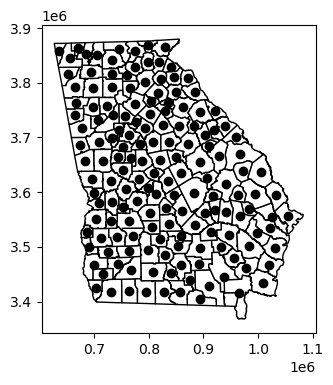

In [8]:
georgia_data = pd.read_csv(ps.examples.get_path('GData_utm.csv'))
georgia_shp = geopandas.read_file(ps.examples.get_path('G_utm.shp'), engine="pyogrio")

fig, ax = plt.subplots(figsize=(4,4))
georgia_shp.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
georgia_shp.centroid.plot(ax=ax, c='black')

Features of the data:
* is rural (PctRural)
* have a college degree (PctBach)
* are elderly (PctEld)
* are foreign born (PctFB)
* are classed as being in poverty (PctPov)
* are black (PctBlack) 

Note: Median income of the county (MedInc) (in 1000s of dollars)

In [9]:
# Prepare inputs
g_y = georgia_data['PctPov'].values.reshape((-1,1))
g_X = georgia_data[['PctFB', 'PctEld', 'PctRural']].values
u = georgia_data['X']
v = georgia_data['Y']
g_coords = list(zip(u,v))

g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [10]:
# Calibrate GWR model (i.e. selecting bandwidth)
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

62.0


In [11]:
len(gwr_results.params)

159

In [12]:
# The coefficients of each regressor
gwr_results.params[0:10]

array([[ 0.46020874,  0.08534573,  0.47845008,  0.12334195],
       [ 0.47236266, -0.09397687,  0.48261836,  0.04019985],
       [ 0.45343074,  0.03775942,  0.46861875,  0.11277671],
       [ 0.55620046, -0.0284382 ,  0.74669989, -0.17448147],
       [ 0.02599193,  0.04350062,  0.76874361,  0.04664889],
       [-0.5770192 , -0.172115  ,  0.34765641, -0.29634058],
       [-0.54290736, -0.10651237,  0.54307715, -0.27327684],
       [-0.83184825, -0.03640225,  0.38889593, -0.03018638],
       [ 0.49901412, -0.10219809,  0.5684553 ,  0.03659828],
       [ 0.50492214, -0.16377078,  0.51401271, -0.04187702]])

In [13]:
# R2 for each localised region
gwr_results.localR2[0:10]

array([[0.51160202],
       [0.51433687],
       [0.52513058],
       [0.63847475],
       [0.55091135],
       [0.57796385],
       [0.62569445],
       [0.6900208 ],
       [0.55594115],
       [0.49312699]])

In [14]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 159
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            105.808
Log-likelihood:                                                    -193.232
AIC:                                                                394.465
AICc:                                                               396.857
BIC:                                                               -679.873
R2:                                                                   0.335
Adj. R2:                                                              0.322

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [15]:
# Prepare GWR results for mapping

# Add GWR parameters to GeoDataframe
georgia_shp['gwr_intercept'] = gwr_results.params[:,0]
georgia_shp['gwr_fb'] = gwr_results.params[:,1]
georgia_shp['gwr_eld'] = gwr_results.params[:,2]
georgia_shp['gwr_rural'] = gwr_results.params[:,3]

# Obtain t-vals filtered based on multiple testing correction
# T statustic with an absolute value smaller than the critical value to 0
gwr_filtered_t = gwr_results.filter_tvals()

In [16]:
def plot_surface(variable, title):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax0 = axes
    ax0.set_title(title)

    #Set color map
    cmap = plt.cm.seismic

    # Find min and max values of the two combined datasets
    gwr_min = georgia_shp[variable].min()
    gwr_max = georgia_shp[variable].max()
    vmin = np.min([gwr_min])
    vmax = np.max([gwr_max])

    # If all values are negative use the negative half of the colormap
    if (vmin < 0) & (vmax < 0):
        cmap = truncate_colormap(cmap, 0.0, 0.5)
    # If all values are positive use the positive half of the colormap
    elif (vmin > 0) & (vmax > 0):
        cmap = truncate_colormap(cmap, 0.5, 1.0)
    # Otherwise, there are positive and negative values so the colormap so zero is the midpoint
    else:
        cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

    # Create scalar mappable for colorbar and stretch colormap across range of data values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    # Plot GWR parameters
    georgia_shp.plot(variable, cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})

    # If there are insignificnt parameters plot gray polygons
    if (gwr_filtered_t[:,0] == 0).any():
        georgia_shp[gwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

    # Set figure options and plot 
    fig.tight_layout()   
    fig.subplots_adjust(right=1.5)
    cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax) 
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)
    plt.show();

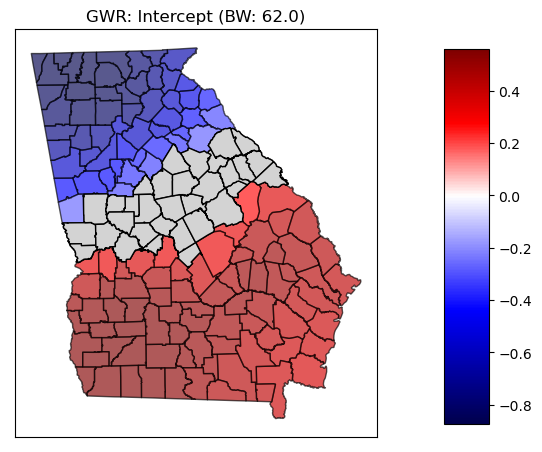

In [17]:
plot_surface(variable='gwr_intercept', title='GWR: Intercept (BW: ' + str(gwr_bw) +')')

/Users/nicole_kan/opt/anaconda3/envs/gdai-env/lib/python3.10/site-packages/pysal/model/mgwr/utils.py:60: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


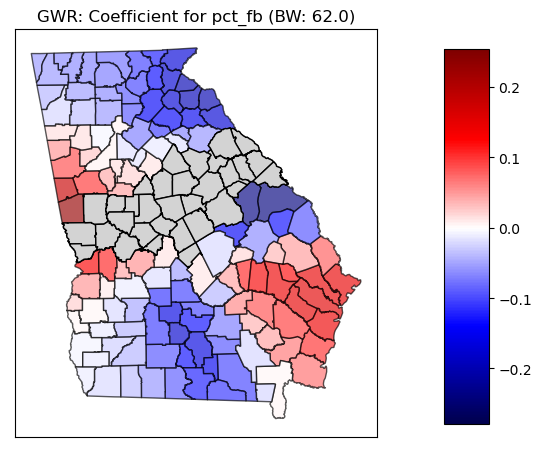

In [18]:
plot_surface(variable='gwr_fb', title='GWR: Coefficient for pct_fb (BW: ' + str(gwr_bw) +')')

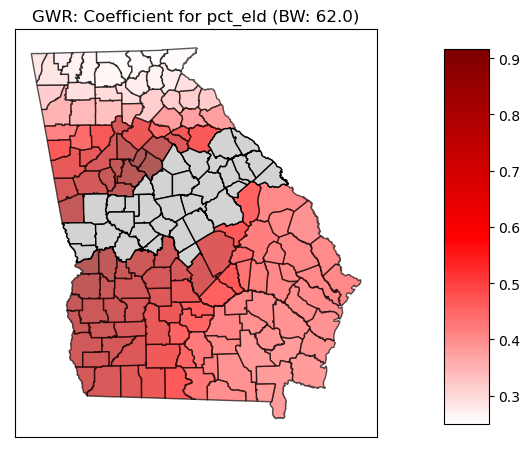

In [19]:
plot_surface(variable="gwr_eld", title='GWR: Coefficient for pct_eld (BW: ' + str(gwr_bw) +')')

/Users/nicole_kan/opt/anaconda3/envs/gdai-env/lib/python3.10/site-packages/pysal/model/mgwr/utils.py:60: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


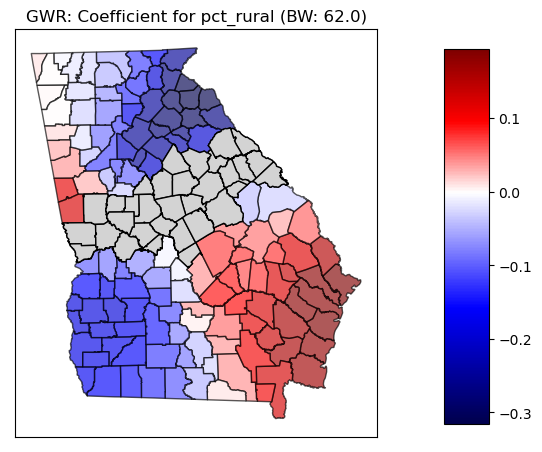

In [20]:
plot_surface(variable="gwr_rural", title='GWR: Coefficient for pct_rural (BW: ' + str(gwr_bw) +')')